In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
# read csv 
import pandas as pd
df = pd.read_csv("C:/Users/dalil/OneDrive/DAlilahuni/Excel/history_37295290-1970-01-01-MAX.csv", sep=';')
df

,Datum,Eröffnung,Hoch,Tief,Schluss,Währung,Volumen
0,29.06.2010,"1,267","1,667","1,169","1,593",USD,2.817491e+08
1,30.06.2010,"1,719","2,028","1,553","1,589",USD,2.579159e+08
2,01.07.2010,"1,667","1,728","1,351","1,464",USD,1.234479e+08
3,02.07.2010,"1,533","1,540","1,247","1,280",USD,7.712711e+07
4,06.07.2010,"1,333","1,333","1,055","1,074",USD,1.031894e+08
...,...,...,...,...,...,...,...
3735,05.05.2025,"284,570","284,849","274,400","280,260",USD,9.461888e+07
3736,06.05.2025,"273,105","277,730","271,350","275,350",USD,7.671579e+07
3737,07.05.2025,"276,880","277,920","271,000","276,220",USD,7.188241e+07
3738,08.05.2025,"279,630","289,800","279,410","284,820",USD,9.753945e+07


In [3]:
# set Datum as the Index and parse as datetime
df['Datum'] = pd.to_datetime(df['Datum'], format="%d.%m.%Y")
df.set_index('Datum', inplace=True)

# fit format
df['Schluss'] = df['Schluss'].str.replace(',', '.').astype(float)

# Wähle den Schlusskurs für die Zeitreihenanalyse
timeseries = df['Schluss']

In [4]:
# Clean the "Close" column
df["Schluss"] = df["Schluss"].replace(',', '', regex=True)
df["Schluss"] = pd.to_numeric(df["Schluss"], errors='coerce')
df["Schluss"].replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["Schluss"], inplace=True)

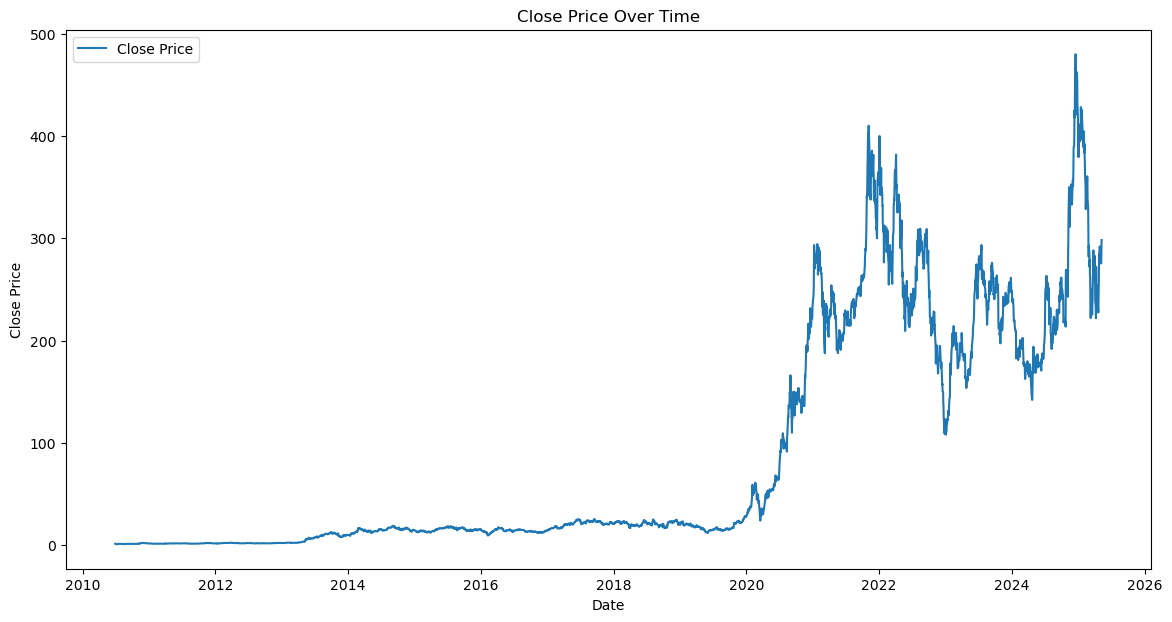

In [5]:
# Plotting the original Close price
plt.figure(figsize=(14, 7))
plt.plot(df.index, df["Schluss"], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

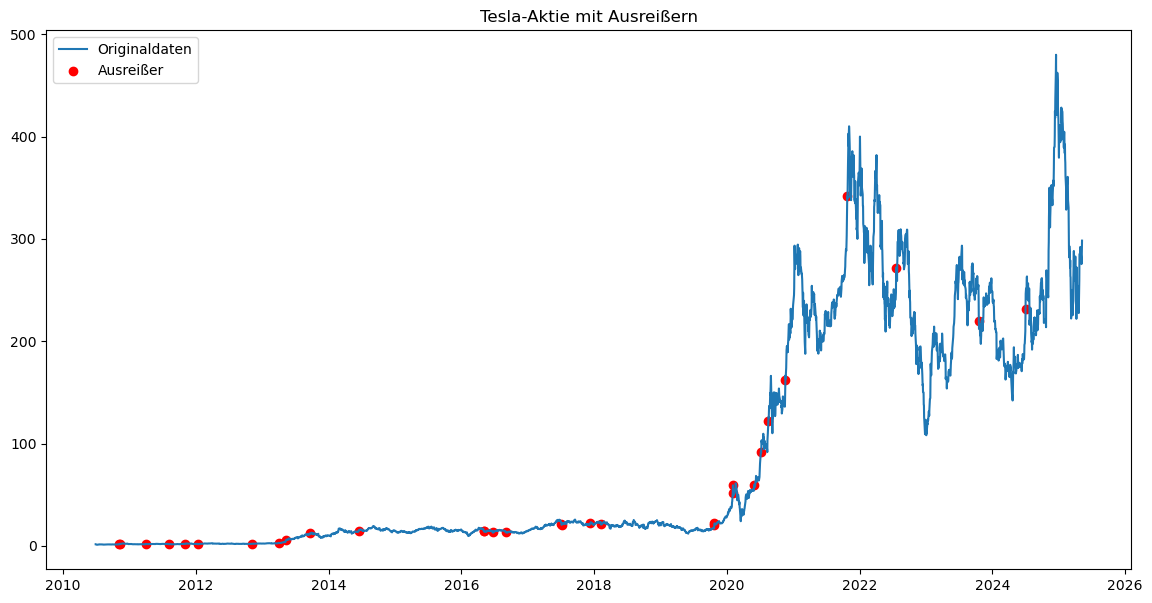

In [6]:
def identify_outliers_rolling(series, window=20, threshold=3):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    
    upper_bound = rolling_mean + threshold * rolling_std
    lower_bound = rolling_mean - threshold * rolling_std
    
    return (series > upper_bound) | (series < lower_bound)

# Maske und Visualisierung
outlier_mask = identify_outliers_rolling(df["Schluss"])
outliers = df[outlier_mask]

plt.figure(figsize=(14, 7))
plt.plot(df.index, df["Schluss"], label="Originaldaten")
plt.scatter(outliers.index, outliers["Schluss"], color="red", label="Ausreißer")
plt.title("Tesla-Aktie mit Ausreißern")
plt.legend()
plt.show()


In [7]:
df["Schluss_cleaned"] = df["Schluss"].copy()
df.loc[outlier_mask, "Schluss_cleaned"] = np.nan
df["Schluss_cleaned"] = df["Schluss_cleaned"].interpolate()


In [8]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(df["Schluss"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
df['Schluss_Diff'] = df['Schluss'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df["Schluss_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Original): -1.2525
p-value (Original): 0.6506
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -10.9740
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


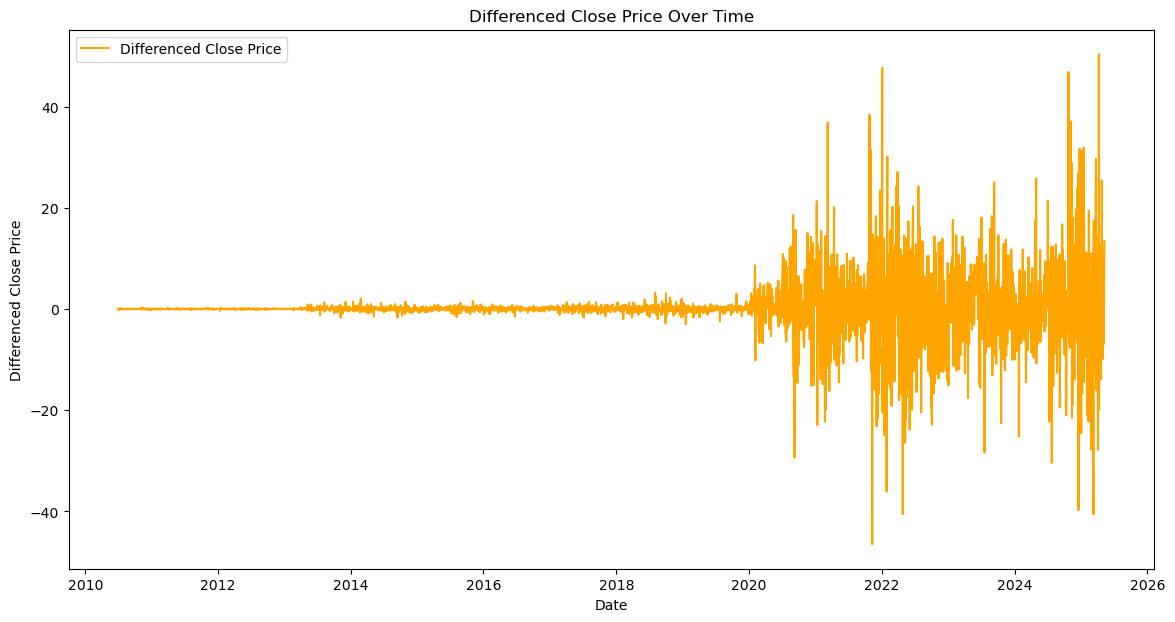

In [9]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Schluss_Diff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

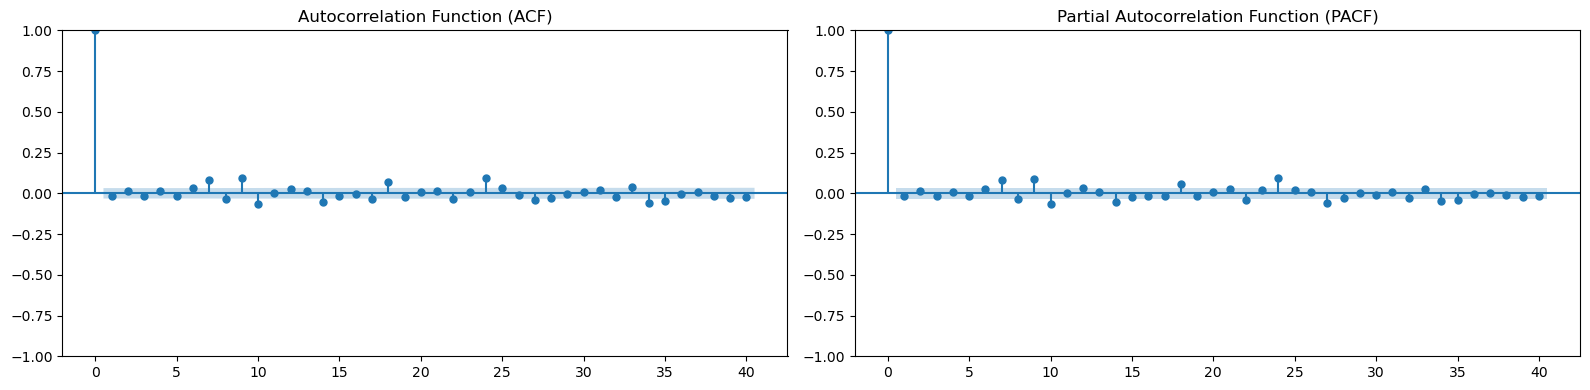

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(df['Schluss_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(df['Schluss_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [11]:
# Split data into train and test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["Schluss"], order=(1,1,1))
model_fit = model.fit()

c:\Users\dalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\dalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\dalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\dalil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


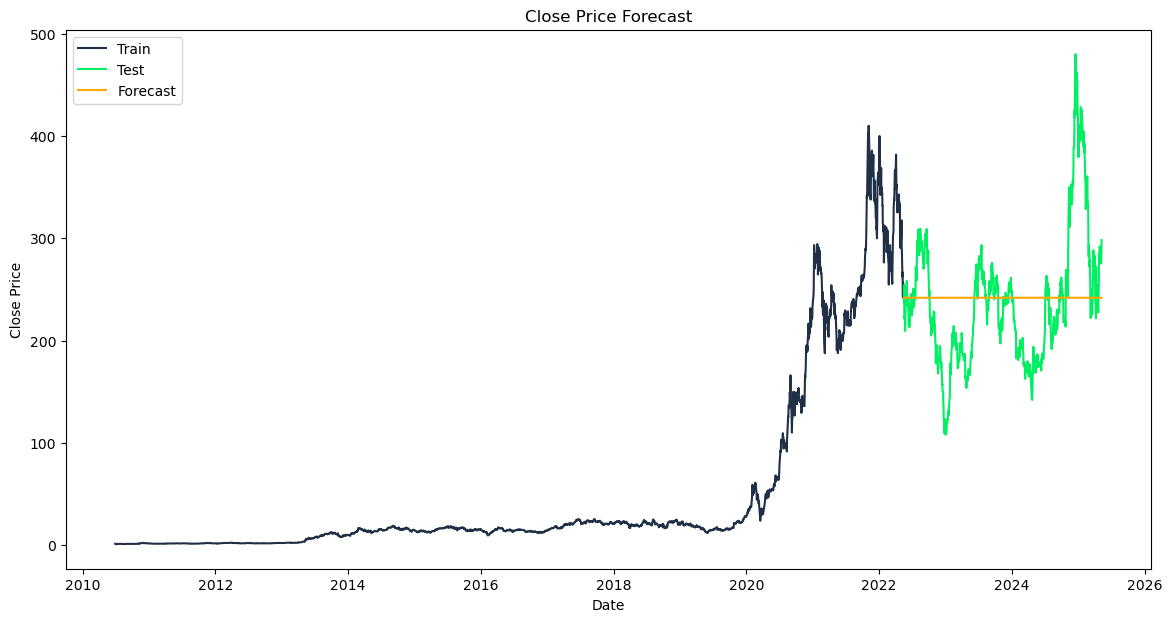

In [12]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["Schluss"], label='Train', color='#203147')
plt.plot(test.index, test["Schluss"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [13]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 16816.277224005582
BIC: 16834.28731318147
